In [2]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version 
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import tensorflow as tf 
assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt 

plt.rc("font", size = 14)
plt.rc("axes", labelsize = 14, titlesize = 14)
plt.rc("legend", fontsize = 14)
plt.rc("xtick", labelsize = 12)
plt.rc("ytick", labelsize = 12)

tf.config.list_physical_devices("GPU")

2025-08-23 13:48:03.717773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-23 13:48:04.197959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755938884.354419     939 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755938884.419653     939 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755938884.895123     939 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sys.modules

{'sys': <module 'sys' (built-in)>,
 'builtins': <module 'builtins' (built-in)>,
 '_frozen_importlib': <module '_frozen_importlib' (frozen)>,
 '_imp': <module '_imp' (built-in)>,
 '_thread': <module '_thread' (built-in)>,
 '_warnings': <module '_warnings' (built-in)>,
 '_weakref': <module '_weakref' (built-in)>,
 '_io': <module '_io' (built-in)>,
 'marshal': <module 'marshal' (built-in)>,
 'posix': <module 'posix' (built-in)>,
 '_frozen_importlib_external': <module '_frozen_importlib_external' (frozen)>,
 'time': <module 'time' (built-in)>,
 'zipimport': <module 'zipimport' (frozen)>,
 '_codecs': <module '_codecs' (built-in)>,
 'codecs': <module 'codecs' (frozen)>,
 'encodings.aliases': <module 'encodings.aliases' from '/usr/lib/python3.12/encodings/aliases.py'>,
 'encodings': <module 'encodings' from '/usr/lib/python3.12/encodings/__init__.py'>,
 'encodings.utf_8': <module 'encodings.utf_8' from '/usr/lib/python3.12/encodings/utf_8.py'>,
 '_signal': <module '_signal' (built-in)>,
 '_ab

In [4]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images[0].shape


(427, 640, 3)

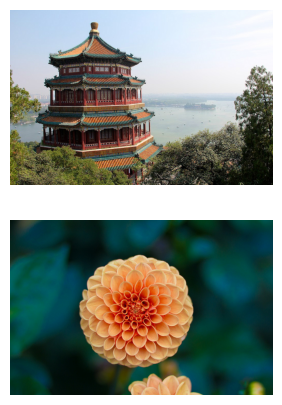

In [5]:
plt.figure(figsize=(5, 5))
plt.subplot(2,1, 1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(2,1, 2)
plt.imshow(images[1])
plt.axis("off")
plt.show()

In [6]:
images = tf.keras.layers.CenterCrop(height = 70, width = 120)(images)
images = tf.keras.layers.Rescaling(scale = 1/255)(images )
images.shape

I0000 00:00:1755938893.840231     939 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


TensorShape([2, 70, 120, 3])

In [7]:
tf.random.set_seed(42)
convLayer = tf.keras.layers.Conv2D(filters =32 , kernel_size=7)
featureMaps = convLayer(images)
featureMaps.shape

I0000 00:00:1755938895.942780     939 cuda_dnn.cc:529] Loaded cuDNN version 90300


TensorShape([2, 64, 114, 32])

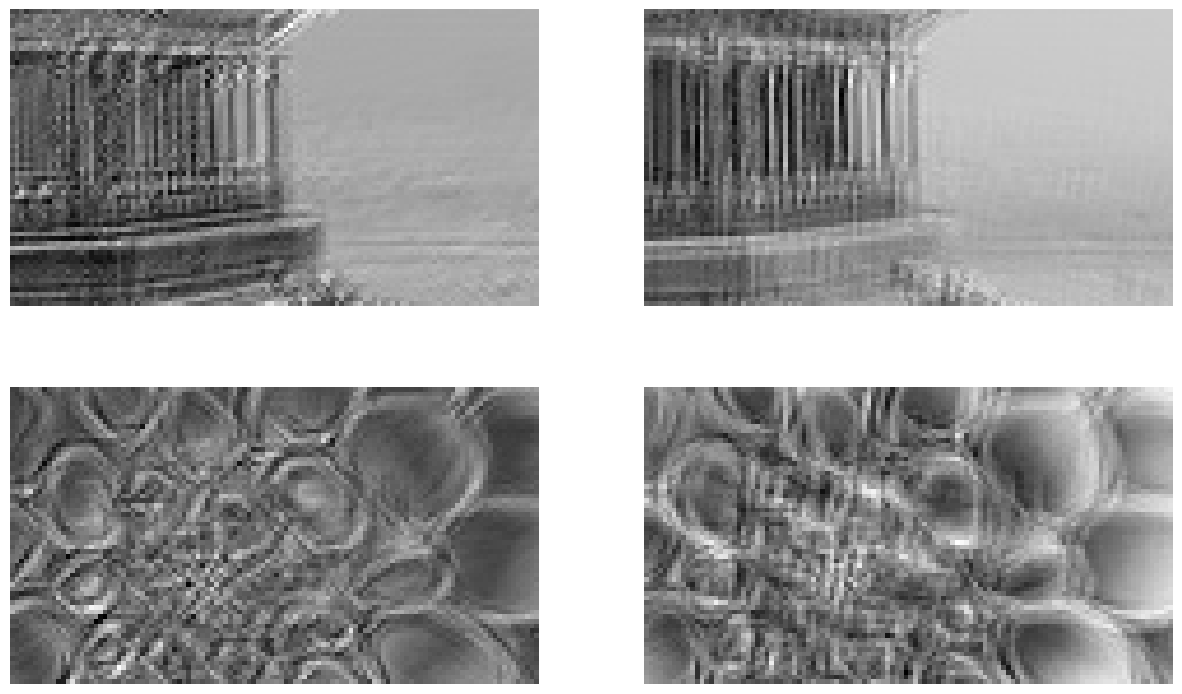

In [8]:
plt.figure(figsize=(15, 9))
for imageId in (0, 1):
    for fmapId in (0,1):
        plt.subplot(2, 2, imageId * 2 + fmapId + 1)
        plt.imshow(featureMaps[imageId, : , : , fmapId], cmap = "gray")
        plt.axis("off")
plt.show()

now with zero padding

In [9]:
convLayerPadding = tf.keras.layers.Conv2D(filters = 32, kernel_size=7, padding="same")
paddedFMaps = convLayerPadding(images)
paddedFMaps.shape

TensorShape([2, 70, 120, 32])

its the same as images shape .
Now with strides

In [10]:
convLayerStridesPadding = tf.keras.layers.Conv2D(
    filters = 32, 
    kernel_size=7, 
    padding="same",
    strides = 2)
paddedStridesFMaps = convLayerStridesPadding(images)
paddedStridesFMaps.shape

TensorShape([2, 35, 60, 32])

In [11]:
weights, biases =convLayer.get_weights()
weights.shape

(7, 7, 3, 32)

manually creating the filters using tf.nn.conv2d

In [ ]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images,filters, strides = 1, padding="SAME") + biases
# numimages. width, height, numfilters
fmaps.shape 

TensorShape([2, 70, 120, 2])

manually creating horizontal and verticle filters

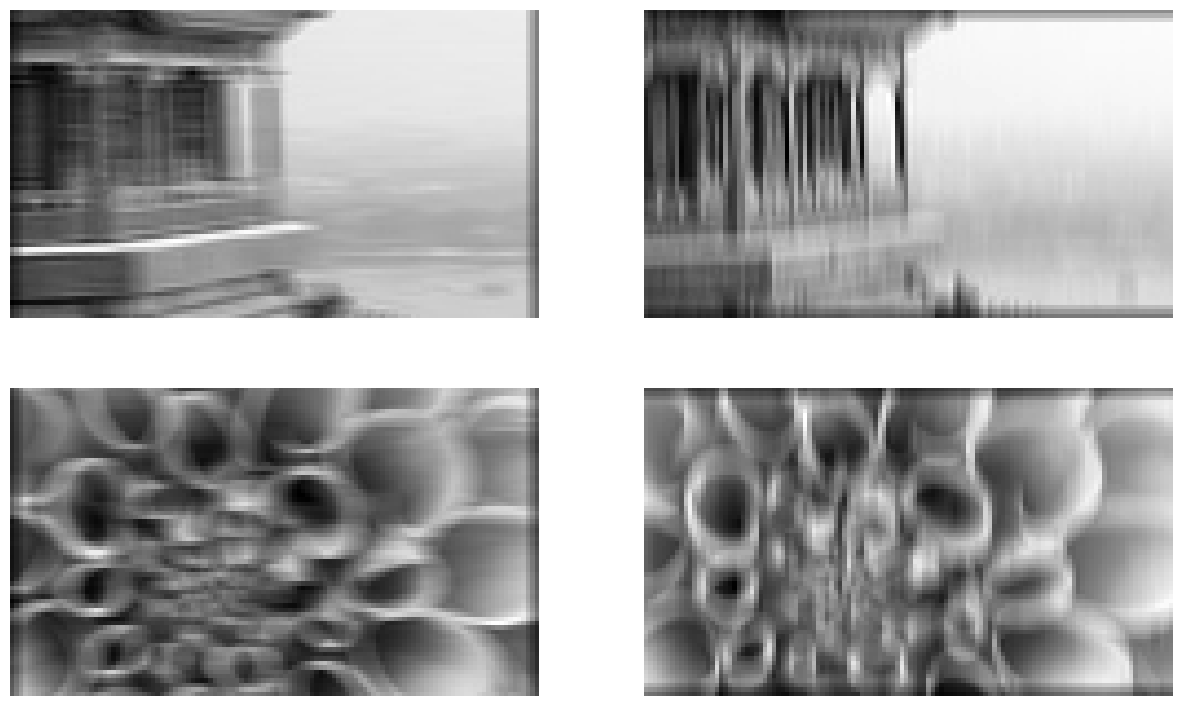

In [25]:
import numpy as np
filters = np.zeros([7, 7, 3, 2])
# horizontal filter
filters[3, :, :, 0] = 1
# verticle filter 
filters[:,3 , :, 1] = 1 
fmaps = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

plt.figure(figsize=(15, 9))
for imageId in (0, 1):
    for fmapId in (0, 1):
        plt.subplot(2,2, imageId * 2 + fmapId + 1)
        plt.imshow(fmaps[imageId, :, :,fmapId], cmap= "gray")
        plt.axis("off")
plt.show()

max pooling example

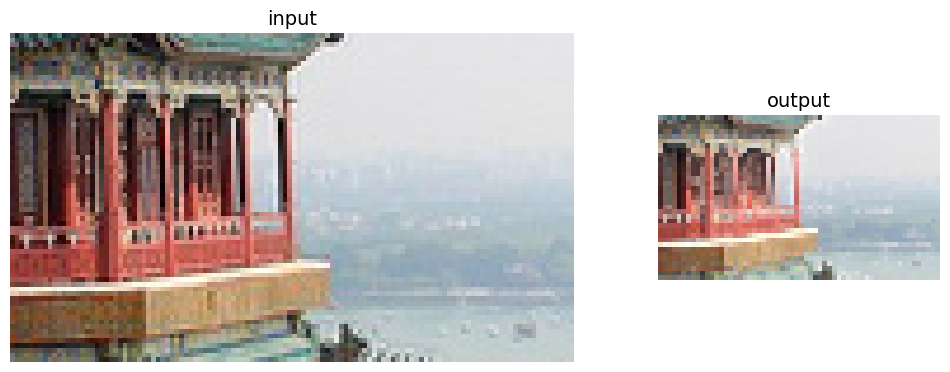

In [30]:
maxPoolLayer = tf.keras.layers.MaxPool2D(pool_size=2)
maxPoolOuput = maxPoolLayer(images)

import matplotlib as mpl 

fig = plt.figure(figsize=(12, 9))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = [2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("input")
ax1.axis("off")
ax1.imshow(images[0])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("output")
ax2.axis("off")
ax2.imshow(maxPoolOuput[0])

plt.show()

In [ ]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60) # last dimension is for number of features
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 60), strides=(1, 1, 1, 60),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 1])

In [ ]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        # print(f"shape : {shape}")
        groups = shape[-1] // self.pool_size  # number of channel groups
        # print(f"groups : {groups}")
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        # print(f"new_shape : {new_shape}")
        test = tf.reshape(inputs, new_shape)
        # print(f"test.shape : {test.shape}")
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)
    
result = DepthPool(pool_size= 3)(images)
result.shape

shape : [  2  70 120   3]
groups : 1
new_shape : [  2  70 120   1   3]
test.shape : (2, 70, 120, 1, 3)


TensorShape([2, 70, 120, 1])

shape : [  2  70 120   3]
groups : 1
new_shape : [  2  70 120   1   3]
test.shape : (2, 70, 120, 1, 3)


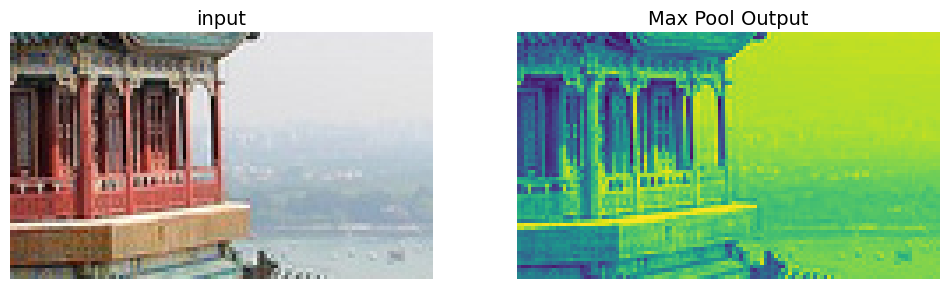

In [52]:
maxPoolImages = DepthPool(pool_size= 3)(images)
# plotting the dept wise max pool image 
plt.figure(figsize=(12, 9))
plt.subplot(1, 2, 1)
plt.title("input")
plt.axis("off")
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Max Pool Output")
plt.axis("off")
plt.imshow(maxPoolImages[0, ..., 0])

plt.show()